In [37]:
from typing import List, Tuple
import pandas as pd
import requests
from io import StringIO
import re
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns

import pytest



def download_stats():
    f1 = "https://www.stat.gouv.qc.ca/statistiques/population-demographie/deces-mortalite/DecesSemaine_QC_2010-2020_GrAge.csv"

    req = requests.get(f1)
    csv = req.text
    df = pd.read_table(StringIO(csv), skiprows=5, sep=";", thousands=" ")

    # Remove comment line #1 and comments at end of file
    df = df[1:45]

    df.iloc[:,3:] = df.iloc[:,3:].replace(" ", "", regex=True).astype(float)
    df = df.drop("Statut", 1)

    return df

In [38]:
df= download_stats()
# df

In [39]:
# Population stats de https://www.stat.gouv.qc.ca/statistiques/population-demographie

population = pd.DataFrame([7929222, 8005090, 8061101, 8110880, 8150183, 8175272, 8225950, 8298827, 8387632, 8484965],
                          index=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
current_population = 8484965
# population

In [40]:
def get_grouping_by_age(groupe_age):
    df = download_stats()
    g = df[df["Groupe d'âge"] == groupe_age]
    g = g.transpose()
    g.drop("Groupe d'âge", inplace=True)
    g.columns = g.iloc[0]
    g = g[1:53]
    return g

In [41]:
age_total = get_grouping_by_age("Total")
age_70_plus = get_grouping_by_age("70 ans et plus")
age_50_69 = get_grouping_by_age("50-69 ans")
age_0_49 = get_grouping_by_age("0-49 ans")


In [42]:
def add_5_years_mean(df, col_name, new_col_name):

    def mean_past_years_per_week(year, span=5):
        for w in range(1, 52+1):
            week_code = f"{year}-{w:02}"

            sum = 0
            for k in range(1, span+1):
                val = df.loc[df.week_code == f"{year-k}-{w:02}", col_name].item()
                sum += val

                df.loc[df.week_code == week_code, new_col_name] = sum / span

    # Recent years, use 5 years for averaging
    for y in range(2015, 2020+1):
        mean_past_years_per_week(y, span=5)

    # We don't have older years, so us less years for averaging those
    mean_past_years_per_week(2014, span=4)
    mean_past_years_per_week(2013, span=3)
    mean_past_years_per_week(2012, span=2)
    mean_past_years_per_week(2011, span=1)
    df.loc[:52, new_col_name] = df.loc[:52, col_name].mean()

    # Test
    for i in range(1, 22+1):
        assert (df.loc[df.week_code == f"2015-{i:02}", col_name].item() +
                df.loc[df.week_code == f"2016-{i:02}", col_name].item() +
                df.loc[df.week_code == f"2017-{i:02}", col_name].item() +
                df.loc[df.week_code == f"2018-{i:02}", col_name].item() +
                df.loc[df.week_code == f"2019-{i:02}", col_name].item() ) / 5 \
               == pytest.approx(df.loc[df.week_code == f"2020-{i:02}", new_col_name].item()), f"Error at i={i}"

def create_averages_df(df, col_deces):
    res = pd.DataFrame(columns=["week_code", col_deces])


    def copy_past_years(year, span, res):
        for w in range(1, 52+1):
            week_code = f"{year}-{w:02}"

            for k in range(1, span+1):
                res = res.append({"week_code": week_code, col_deces: df.loc[df.week_code == f"{year-k}-{w:02}", col_deces].item()},ignore_index=True)

        return res

    for year in range(2015, 2020+1):
        res = copy_past_years(year, 5, res)

    res = copy_past_years(2014, 4, res)
    res = copy_past_years(2013, 3, res)
    res = copy_past_years(2012, 2, res)
    res = copy_past_years(2011, 1, res)

    return res


# def add_rolling_mean(df, col_name, new_col_name, window):
#     df[new_col_name] = df.loc[:, col_name].rolling(window=window).mean()
#     # df[new_col_name] = df[new_col_name].shift(-window // 2)
#
# def add_mean(df, col_name, new_col_name):
#     df[new_col_name] = df.loc[:, col_name].mean()

# def add_constant(df, new_col_name, value):
#     df[new_col_name] = value

def create_df(values, rolling_window=52):
    s = []
    w = []
    d = []

    for i in range(2010, 2020+1):
        yd = values[f"{i}"].array
        s.extend([f"{i}"] + [f"{x}" if (x % 13==0) and x<52 else "" for x in range(1, len(yd))])
        w.extend([f"{i}-{w+1:02}" for w in range(len(yd))])
        d.extend(yd)

    df = pd.DataFrame({"semaine_label" : s, "week_code" : w, "deces" : d})

    for i in range(2010, 2020):
        df.loc[df.week_code == f"{i}-01", "population"] = population.iloc[i-2010].item()
    df.loc[df.week_code == "2020-52", "population"] = population.iloc[-1].item()
    
    # Add normalized population column
    df["population"] = df["population"].interpolate()
    df["deces_norm"] = df.deces * current_population / df["population"]

    # add mean column
    add_5_years_mean(df, "deces", "av")
    add_5_years_mean(df, "deces_norm", "av_norm")

    #
    # if mean_type == "rolling":
    #     add_rolling_mean(df, "deces", "av", rolling_window)
    #     add_rolling_mean(df, "deces_norm", "av_norm", rolling_window)
    # elif mean_type == "global":
    #     add_mean(df, "deces", "av")
    #     add_mean(df, "deces_norm", "av_norm")

    # Extend the missing, up to the season limit
    value = df.loc[rolling_window-1, "av"].item()
    value_norm = df.loc[rolling_window-1, "av_norm"].item()
    df.loc[:rolling_window, "av"] = value
    df.loc[:rolling_window, "av_norm"] = value_norm

    # Diff 
    df["diff_deces"] = (df["deces"] - df["av"])
    df["diff_deces_norm"] = (df["deces_norm"] - df["av_norm"])

    return df

In [43]:
df_total = create_df(age_total)
df_70_plus = create_df(age_70_plus)
df_50_69 = create_df(age_50_69)
df_0_49 = create_df(age_0_49)

In [44]:
def integrate_seasons(df, col):

    season_totals = {}
    
    for i in range(2011, 2020+1):
        left = f"{i-1}-44"
        right = f"{i}-22"

        i1 = df.index[df['week_code'] == left].item()
        i2 = df.index[df['week_code'] == right].item()
        season_totals[i] = df.loc[i1:i2, col].sum()

    return season_totals

def integrate_year(df, col):

    season_totals = {}
    
    for i in range(2011, 2020):
        left = f"{i}-01"
        right = f"{i}-52"

        i1 = df.index[df['week_code'] == left].item()
        i2 = df.index[df['week_code'] == right].item()
        season_totals[i] = df.loc[i1:i2, col].sum()

    return season_totals

In [45]:
def draw_seasons(df, ax, col_deces, col_av52, col_diff_deces):
    for i in range(2011, 2020+1):
        left = f"{i-1}-44"
        right = f"{i}-22"

        plt.axvline(x=f"{i}-01", c="grey", alpha=0.10)
        plt.axvspan(xmin=left, xmax=right, color="tab:gray", alpha=0.1)

        i1 = df.index[df['week_code'] == left].item()
        i2 = df.index[df['week_code'] == right].item() + 1
        
        # Fill from 0 to average
        ax.fill_between(df["week_code"][i1:i2], 0, df[col_av52][i1:i2], 
                        facecolor='tab:blue', alpha=0.2)

        # Fill from average to top
        ax.fill_between(df["week_code"][i1:i2], df[col_av52][i1:i2], df[col_deces][i1:i2], 
                        where=df[col_diff_deces][i1:i2] > 0, facecolor='tab:red', alpha=0.2)
        
def draw_lineplot(df, group_title, col_deces, col_av, col_diff_deces, rolling_window=52, top_y = 2300, annotations=True):
    # df = create_df(values, rolling_window)
    averages = create_averages_df(df, col_deces)

    fig, ax = plt.subplots(figsize=(20, 8))
    plt.subplots_adjust(top=0.8)

    g = sns.lineplot(x="week_code", y=col_deces, data=df, label="Décès par semaine", color="tab:blue")
    sns.lineplot(x="week_code", y=col_deces, data=averages, label=f"Moyenne des {rolling_window} semaines précédentes", color="tab:orange")
    # sns.lineplot(x="week_code", y=col_av, data=df, label=f"Moyenne des {rolling_window} semaines précédentes", color="tab:orange")

    g.set_xticklabels(df["semaine_label"])

    ax.set(xlabel="Semaines", ylabel="Decès", title="")

    draw_seasons(df, ax, col_deces, col_av, col_diff_deces)
    
    # Title
    group_title_formatted = group_title.replace(" ", "\ ")
    plt.text(52*5, top_y+300, f"Décès par semaine au Québec, $\\bf{{toutes\ causes\ confondues}}$\n$\\bf{{ {group_title_formatted} }}$", fontsize="xx-large", ha="center")

    # Totals whole year header
    plt.text(50, 100, "Total pour l'année:", fontsize="large", ha="right", color="grey")
    year_totals = integrate_year(df, col_deces)
    for i, v in enumerate(year_totals.values()):
        plt.text((i+1) * 52 + 26, 100, int(v), fontsize="large", ha="center", color="grey")
        plt.annotate("", xytext = ((i+1) * 52, 80), xy = ((i+1) * 52 + 52, 80), color="grey ", arrowprops = {"facecolor" : "grey", "arrowstyle": "<|-|>"})

    # Totals header
    plt.text(36, top_y+125, "Total par saison grippale:", fontsize="large", ha="right", color="tab:blue")
    season_totals = integrate_seasons(df, col_deces)
    for i, v in enumerate(season_totals.values()):
        plt.text((i+1) * 52 + 7, top_y+125, int(v), fontsize="large", ha="center", color="tab:blue")

    # Excess header
    plt.text(36, top_y+50, "Excès p/r à la moyenne:", fontsize="large", ha="right", color="tab:red")
    season_totals_diff_over_mean = integrate_seasons(df, col_diff_deces)
    for i, v in enumerate(season_totals_diff_over_mean.values()):
        plt.text((i+1) * 52 + 7, top_y+50, int(v), fontsize="large", ha="center", color="tab:red")


    if annotations:
        # Lockdown date
        plt.axvline(x="2020-12", c="red", alpha=0.25)
        plt.annotate("Début du confinement au Québec (16 mars 2020)",
            ha = "center", va = "bottom",
            xytext = (52*8, top_y-100), xy = (52*10+12, top_y-200),
            arrowprops = {"facecolor" : "black", "arrowstyle": "-|>", "connectionstyle": "angle,angleA=0,angleB=-45,rad=10"})

        plt.annotate("1er janvier",
            ha = "center", va = "bottom",
            xytext = (52*7, top_y-200),xy = (52*8, top_y-250),
            arrowprops = {"facecolor" : "black", "arrowstyle": "-|>", "connectionstyle": "angle,angleA=0,angleB=-45,rad=10"})

        plt.annotate("", xytext = (52*7-10, top_y-380 ),xy = (52*7+22, top_y-380),arrowprops = {"facecolor" : "black", "arrowstyle": "<|-|>"})
        plt.text(52*7 + 7, top_y - 350, "Saison\ngrippale", ha="center")

    plt.xticks(rotation=90)
    ax.set_ylim([0, top_y])

    fig.text(0.90, 0.0, 'github.com/yanickc', fontsize=20, color='gray', ha='right', va='bottom', alpha=0.5)
    plt.show()

    fig.savefig(f"images/line_graph_{group_title.replace(' ', '_')}.png")

In [52]:
def draw_barplot(df, group_title):
    # df = create_df(values)
    season_totals = integrate_seasons(df, col="deces_norm")

    st = pd.DataFrame({"annee":list(season_totals.keys()), "deces": list(season_totals.values())})
    st.columns = ["annee", "deces"]
    # st.index.name = "annee"
    # st = st.transpose()
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.subplots_adjust(top=0.8)

    g = sns.barplot(x="annee", y="deces", data=st, palette="Blues_d", ax=ax)
    
    for index, row in st.iterrows():
        g.text(x=row.name, y=(int(row.deces) * 0.95), s=int(row.deces), color='white', va="center", ha="center",fontsize="x-large")

    group_title_formatted = group_title.replace(" ", "\ ")
    plt.title(f"Décès au Québec $\\bf{{toutes\ causes\ confondues}}$\npar saison grippale\n[de novembre à mai (semaines CDC 44 à 22)]\n"
              f"$\\bf{{ {group_title_formatted} }}$",
              fontsize="xx-large")

    fig.text(0.90, 0.0, 'github.com/yanickc', fontsize=20, color='gray', ha='right', va='bottom', alpha=0.5)

    plt.show()

    fig.savefig(f"images/bar_graph_{group_title.replace(' ', '_')}.png",pad_inches=0.5)

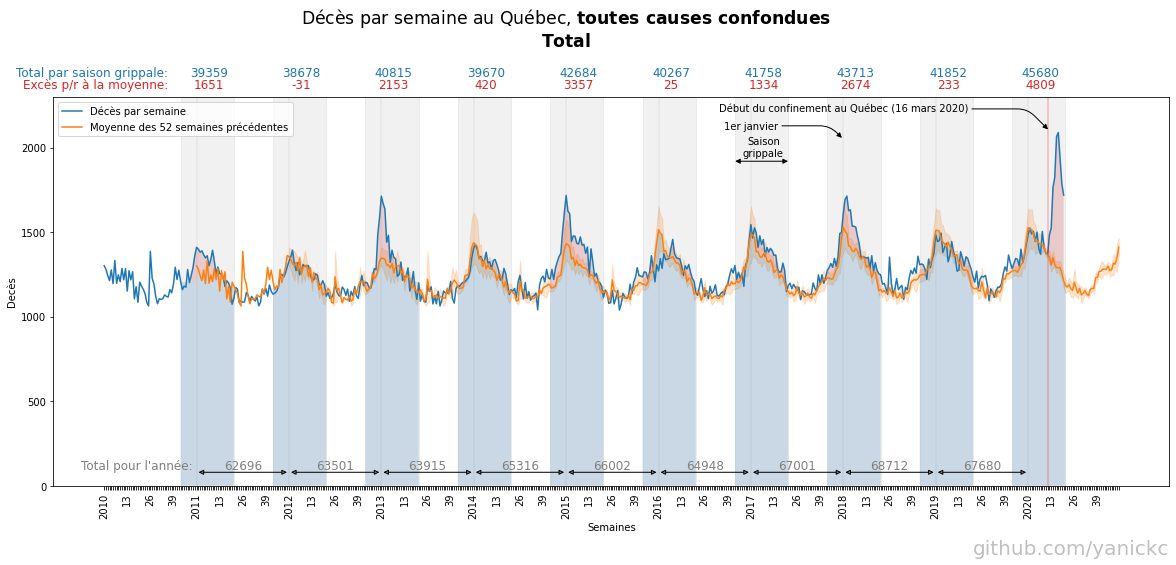

In [47]:
draw_lineplot(df_total, "Total", "deces_norm", "av_norm", "diff_deces_norm", top_y=2300)

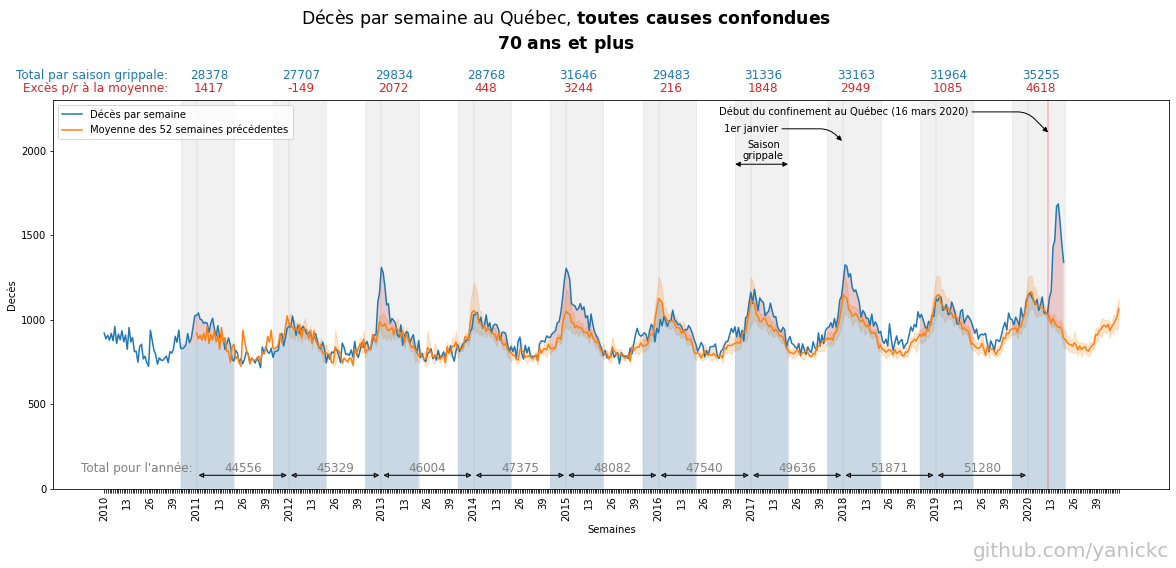

In [48]:
draw_lineplot(df_70_plus, "70 ans et plus", "deces_norm", "av_norm", "diff_deces_norm", top_y=2300)

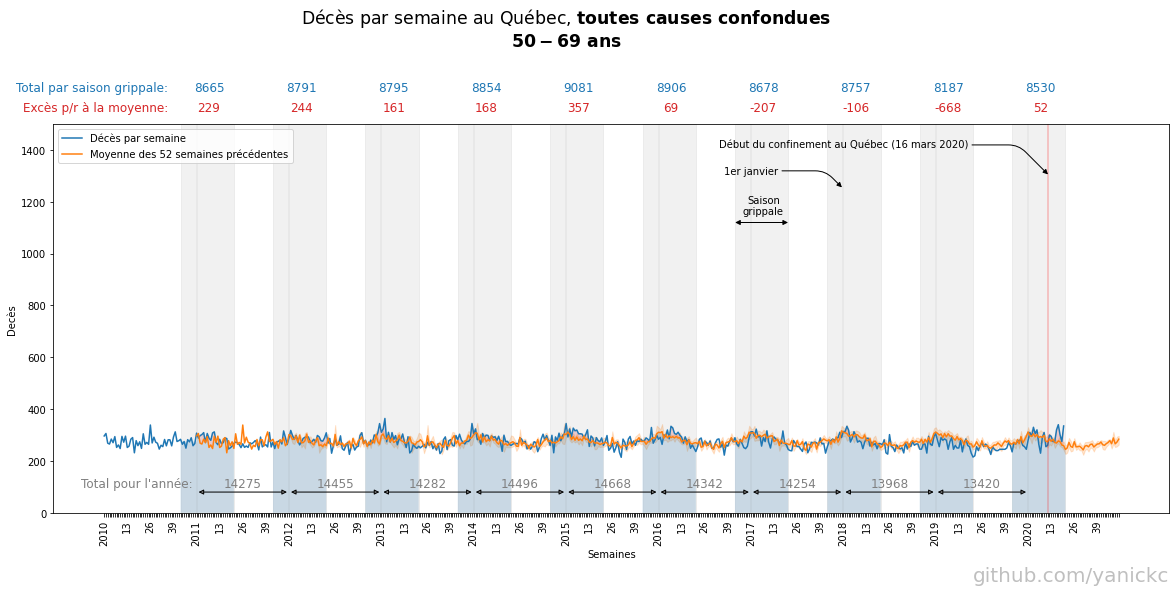

In [49]:
draw_lineplot(df_50_69, "50-69 ans", "deces_norm", "av_norm", "diff_deces_norm", top_y=1500)

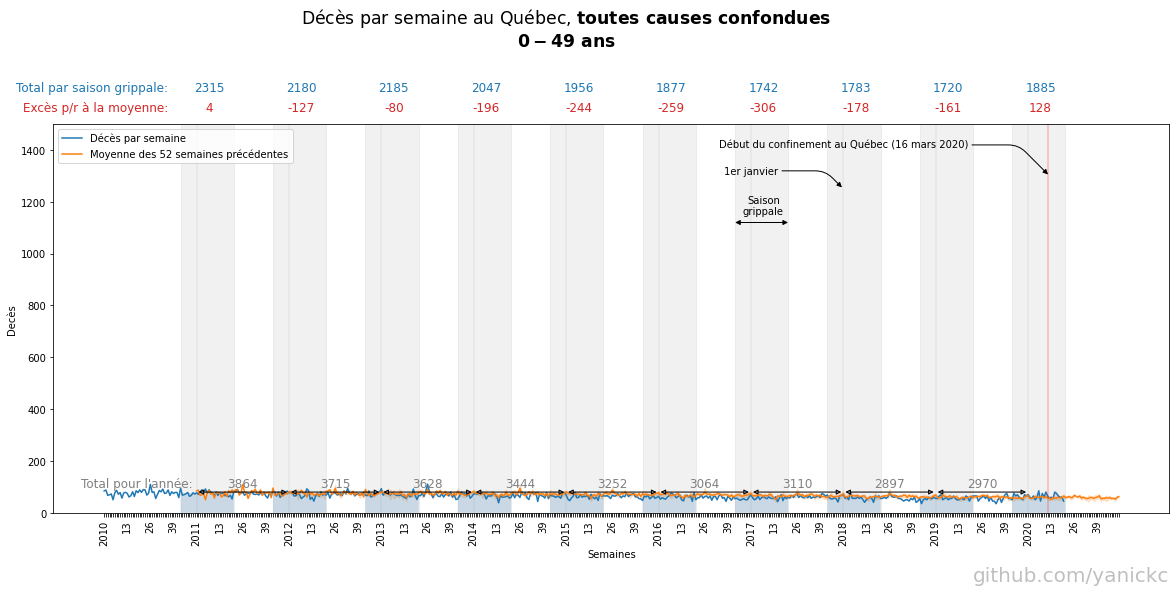

In [50]:
draw_lineplot(df_0_49, "0-49 ans", "deces_norm", "av_norm", "diff_deces_norm", top_y=1500)

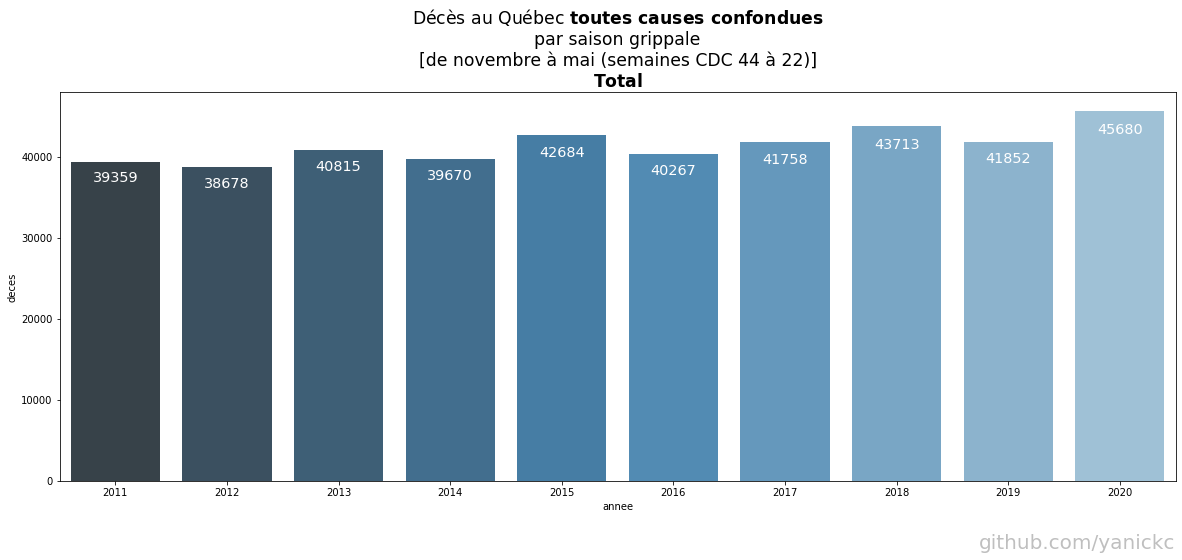

In [53]:
draw_barplot(df_total, "Total")

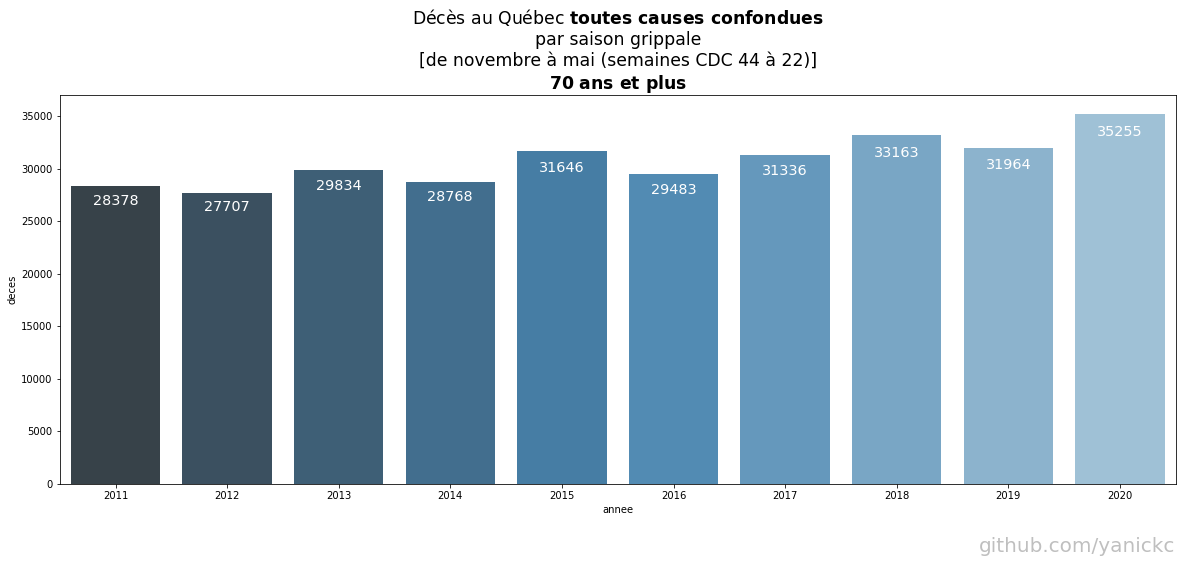

In [54]:
draw_barplot(df_70_plus, "70 ans et plus")

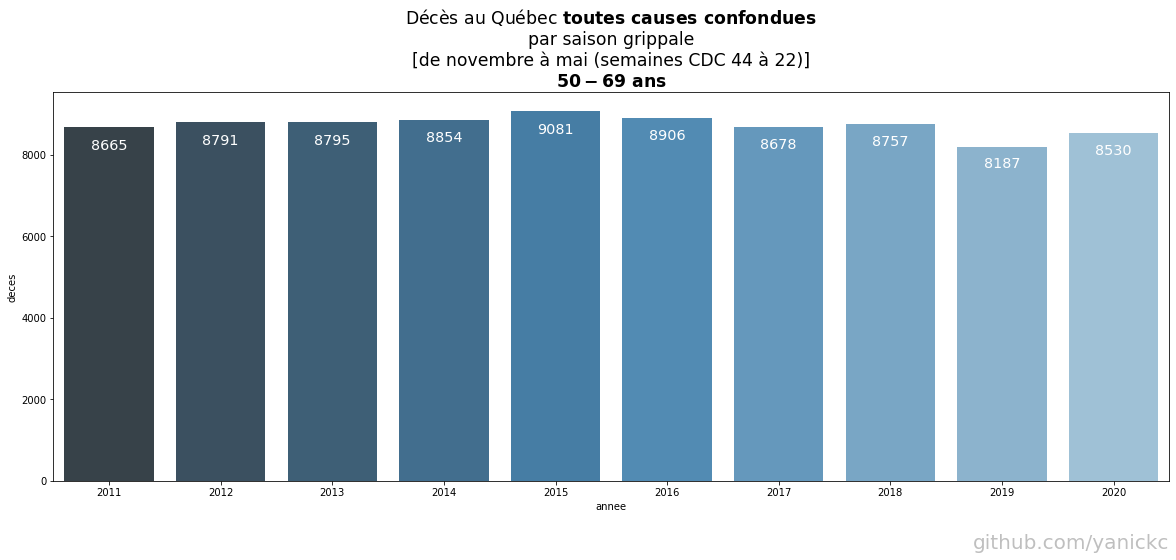

In [55]:
draw_barplot(df_50_69, "50-69 ans")

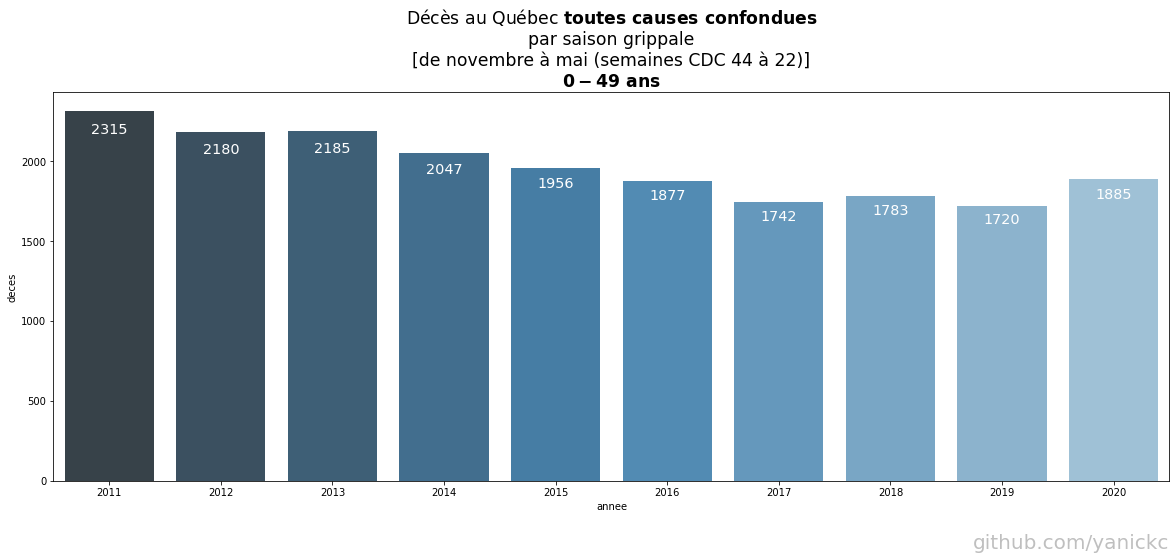

In [56]:
draw_barplot(df_0_49, "0-49 ans")